In [1]:
from scipy import io
from scipy.stats import pearsonr

import numpy as np
import pandas as pd
import seaborn as sns

from neurodsp import spectral
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series
from neurodsp.utils import create_times

from fooof import FOOOF
from fooof.analysis import get_band_peak_fm

from bycycle.features import compute_features
from bycycle.group import compute_features_2d
from bycycle.plts import plot_burst_detect_summary, plot_feature_categorical
from bycycle.utils import flatten_dfs

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt

/var/folders/s6/21s_2dfj2f195fl1lglp7jrw0000gn/T/ipykernel_42951/3209615788.py:13: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [107]:
#data = io.loadmat('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Dyad1Exp2/Dyad1Exp2vOBrrByMousePost.mat', squeeze_me=True)
data = np.loadtxt('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad1Exp2/Dyad1Exp2_bymousePre.txt') 
movement_data = pd.read_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Movement/MovementData-D1E2-ByPre.csv')
num_samples = len(data)
fs = 1000 #originally 30,000 - previously downsampled

Time = np.arange(0, num_samples / fs, 1 / fs)

data = pd.DataFrame({'Time': Time, 'EEG_Signal': data})
movement_data.head()

,Mouse,Movement,Movement_type,Start_time,End_time,Duration
0,byallosniffing,1,5,41.044,42.168,1.124
1,byallosniffing,1,5,58.357,60.214,1.857
2,byallosniffing,1,5,149.415,150.000,0.585
3,byallosniffing,1,5,169.028,169.698,0.670
4,byallosniffing,1,5,188.600,194.590,5.990


In [108]:
#Filter Data based on movement info (0: not moving)
moving_periods = movement_data[movement_data['Movement'] == 1]
moving_eeg_data = pd.DataFrame(columns=['Time', 'EEG_Signal'])
moving_data_segments = []

for _, row in moving_periods.iterrows():
    start, end = row['Start_time'], row['End_time']
    
    segment = data.loc[(data['Time'] >= start) & (data['Time'] <= end)]
    
    moving_data_segments.append(segment)

moving_data = pd.concat(moving_data_segments, ignore_index=True)
moving_data

,Time,EEG_Signal
0,41.044,0.978162
1,41.045,0.932831
2,41.046,0.888847
3,41.047,0.846275
4,41.048,0.805170
...,...,...
312637,121.900,-1.160030
312638,121.901,-1.158125
312639,121.902,-1.154369
312640,121.903,-1.148714


/var/folders/s6/21s_2dfj2f195fl1lglp7jrw0000gn/T/ipykernel_42951/1360055855.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq_mean), np.log10(P_mean))


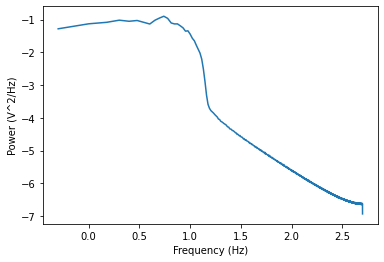

[  0.    0.5   1.  ... 499.  499.5 500. ]
[-2.00738318 -1.28337726 -1.13092351 ... -6.62350145 -6.62510055
 -6.93009713]


In [109]:
# Calculate power spectra
data = moving_data['EEG_Signal'].values
Time = moving_data['Time']
freq_mean, P_mean = spectral.compute_spectrum(data, fs, method='welch', window='hann', nperseg=fs*2) # mean of spectrogram (Welch)
# This breaks the data up into two-second windows (nperseg=fs*2)
# It then applies a hanning window to the time-series windows (window='hann')
# It then FFTs each hanning'd window, and then averages all those FFTs (method='welch')

# Plot PSD
plt.plot(np.log10(freq_mean), np.log10(P_mean))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
#plt.xlim((1, 50))
#plt.ylim((-8, 5))
plt.show()

print(freq_mean)
print(np.log10(P_mean))


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.10 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

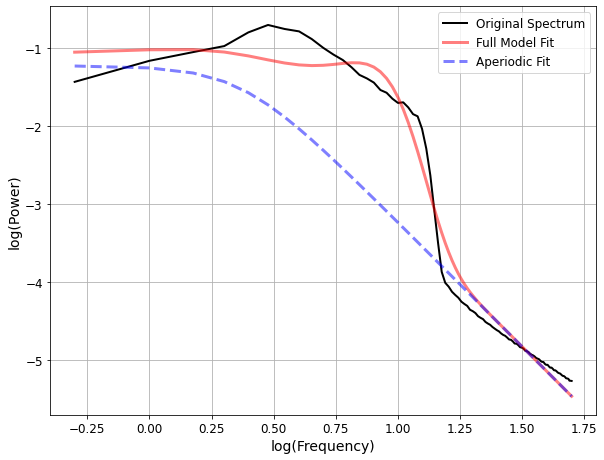

In [63]:
# Initialize a FOOOF object
fm = FOOOF(max_n_peaks = 1, peak_width_limits=[0.1, 50.0], aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.5, 50]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freq_mean, P_mean, freq_range, plt_log=True)

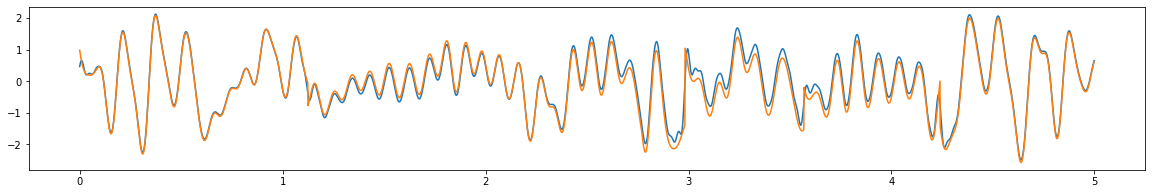

In [110]:
F_RANGE = (4, 12)
preprocess_f_range = (0.5, 30)

#preprocess data in 0.5 to 30 Hz range to get rid of any significant noise 
preproc_sig = filter_signal(data, fs, 'bandpass', preprocess_f_range, remove_edges=False)
#preprocess data in the frequency band of interest (aka the frequency band bycycle will be searching in) 

#use this data for later visualizations 
preproc_sig2 = filter_signal(data, fs, 'bandpass', F_RANGE, remove_edges=False)

# Plot raw and preprocessed signal
%matplotlib inline
times = create_times(len(preproc_sig) / fs, fs)
plt.figure(figsize=(20,3))
plt.plot(times[0:5000], preproc_sig[0:5000])
plt.plot(times[0:5000], data[0:5000])
plt.show()

In [106]:
# Tuned burst detection parameters
threshold_kwargs = {'amp_fraction_threshold': 0.1,
                    'amp_consistency_threshold': 0.2,
                    'period_consistency_threshold': 0.35,
                    'monotonicity_threshold': 0.85,
                    'min_n_cycles': 3}

# Compute waveform shape features for each mouse/exp 
#bycycle_2Post = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_2Pre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_2ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_2ByPre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_ByPre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_Post = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#bycycle_Pre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)  

#save output file locally
bycycle_2ByPost.to_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/Dyad1Exp2/bycycle_2ByPost.txt', sep='\t', index=False)

In [46]:
#check the number of bursts in data 

num_bursts = df_bycycle_ByPre['is_burst'].sum()

total_cycles = len(df_bycycle_ByPre)

print(f"Number of bursts: {num_bursts}")
print(f"Total number of cycles: {total_cycles}")
print(f"Percentage of cycles in bursts: {num_bursts / total_cycles * 100:.2f}%")

Number of bursts: 2999
Total number of cycles: 6717
Percentage of cycles in bursts: 44.65%


In [114]:
# Filter the DataFrames where 'is_burst' is True
bycycle_Pre_burst = bycycle_Pre[bycycle_Pre['is_burst'] == True]
bycycle_Post_burst = bycycle_Post[bycycle_Post['is_burst'] == True]
bycycle_ByPre_burst = bycycle_ByPre[bycycle_ByPre['is_burst'] == True]
bycycle_ByPost_burst = bycycle_ByPost[bycycle_ByPost['is_burst'] == True]
bycycle_2Pre_burst = bycycle_2Pre[bycycle_2Pre['is_burst'] == True]
bycycle_2Post_burst = bycycle_2Post[bycycle_2Post['is_burst'] == True]
bycycle_2ByPre_burst = bycycle_2ByPre[bycycle_2ByPre['is_burst'] == True]
bycycle_2ByPost_burst = bycycle_2ByPost[bycycle_2ByPost['is_burst'] == True]

# bycycle params of interest 
breathing_variables = ['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak'] 

#mouse id - bystander in exp 1 is mouse 2 
#group - Bystander = 2
bycycle_ByPost_burst = bycycle_ByPost_burst[breathing_variables].copy()
bycycle_ByPost_burst['time'] = 2
bycycle_ByPost_burst['group'] = 2
bycycle_ByPost_burst['experiment'] = 1
bycycle_ByPost_burst['mouse_id'] = 2

bycycle_ByPre_burst = bycycle_ByPre_burst[breathing_variables].copy()
bycycle_ByPre_burst['time'] = 1
bycycle_ByPre_burst['group'] = 2
bycycle_ByPre_burst['experiment'] = 1
bycycle_ByPre_burst['mouse_id'] = 2

bycycle_Post_burst = bycycle_Post_burst[breathing_variables].copy()
bycycle_Post_burst['time'] = 2
bycycle_Post_burst['group'] = 1
bycycle_Post_burst['experiment'] = 1
bycycle_Post_burst['mouse_id'] = 1

bycycle_Pre_burst = bycycle_Pre_burst[breathing_variables].copy()
bycycle_Pre_burst['time'] = 1
bycycle_Pre_burst['group'] = 1
bycycle_Pre_burst['experiment'] = 1
bycycle_Pre_burst['mouse_id'] = 1

bycycle_2ByPost_burst = bycycle_2ByPost_burst[breathing_variables].copy()
bycycle_2ByPost_burst['time'] = 2
bycycle_2ByPost_burst['group'] = 2
bycycle_2ByPost_burst['experiment'] = 2
bycycle_2ByPost_burst['mouse_id'] = 1

bycycle_2ByPre_burst = bycycle_2ByPre_burst[breathing_variables].copy()
bycycle_2ByPre_burst['time'] = 1
bycycle_2ByPre_burst['group'] = 2
bycycle_2ByPre_burst['experiment'] = 2
bycycle_2ByPre_burst['mouse_id'] = 1

bycycle_2Post_burst = bycycle_2Post_burst[breathing_variables].copy()
bycycle_2Post_burst['time'] = 2
bycycle_2Post_burst['group'] = 1
bycycle_2Post_burst['experiment'] = 2
bycycle_2Post_burst['mouse_id'] = 2

bycycle_2Pre_burst = bycycle_2Pre_burst[breathing_variables].copy()
bycycle_2Pre_burst['time'] = 1
bycycle_2Pre_burst['group'] = 1
bycycle_2Pre_burst['experiment'] = 2
bycycle_2Pre_burst['mouse_id'] = 2

all_data = pd.concat([bycycle_2ByPost_burst, bycycle_2ByPre_burst, bycycle_2Post_burst, bycycle_2Pre_burst, bycycle_ByPost_burst, bycycle_ByPre_burst, bycycle_Post_burst, bycycle_Pre_burst], ignore_index=True)
print(all_data)

       time_rdsym  time_ptsym  period  time_trough  time_rise  time_decay  \
0        0.495050    0.500000     101           50         50          51   
1        0.460000    0.510000     100           49         46          54   
2        0.504673    0.500000     107           53         54          53   
3        0.523810    0.495327     105           54         55          50   
4        0.516949    0.508621     118           57         61          57   
...           ...         ...     ...          ...        ...         ...   
20293    0.520000    0.342657     100           94         52          48   
20294    0.337838    0.633588     148           48         50          98   
20295    0.562500    0.429688     112           73         63          49   
20296    0.459677    0.538462     124           54         57          67   
20297    0.425532    0.561151     141           61         60          81   

       time_peak  time  group  experiment  mouse_id  
0             50     

In [115]:
#save combined data locally 
#aggregated_data = all_data.groupby(['group', 'time', 'experiment', 'mouse_id'])['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak'].mean().reset_index()
all_data.to_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Mouse_Respiration/ALL_DATA_ANOVA_Moving.txt', sep='\t', index=False)

#print(aggregated_data.dtypes)
#print(aggregated_data.isnull().sum())  # Check for missing values

In [ ]:
##ANALYSES

In [255]:
#aggregated_data['group'] = aggregated_data['group'].astype('category')
#aggregated_data['time'] = aggregated_data['time'].astype('category')
#aggregated_data['experiment'] = aggregated_data['experiment'].astype('category')

# RM ANOVA
for variables in breathing_variables:
    print(f"Running ANOVA for {}")
    
    # Fit the model
    model = smf.ols(f'{dv} ~ C(group) * C(time) + C(experiment)', data=aggregated_data).fit()
    
    # Perform the ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Print the results for each dependent variable
    print(anova_table)
    print("\n" + "="*50 + "\n")

# Post-hoc pairwise comparisons for 'group'
#posthoc_group = pg.pairwise_ttests(dv='period', between='group', data=aggregated_data, padjust='bonferroni')
#print(posthoc_group)

# Post-hoc pairwise comparisons for interaction 'group * time'
#posthoc_group_time = pg.pairwise_ttests(dv='period', between=['group', 'time'], data=aggregated_data, padjust='bonferroni')
#print(posthoc_group_time)

Running ANOVA for time_rdsym
                    sum_sq   df         F    PR(>F)
C(group)          0.000108  1.0  0.290198  0.627500
C(time)           0.000284  1.0  0.760574  0.447331
C(experiment)     0.000216  1.0  0.577110  0.502690
C(group):C(time)  0.000157  1.0  0.419774  0.563216
Residual          0.001121  3.0       NaN       NaN


Running ANOVA for time_ptsym
                        sum_sq   df         F    PR(>F)
C(group)          2.154869e-07  1.0  0.015768  0.908015
C(time)           1.528200e-05  1.0  1.118223  0.367918
C(experiment)     8.939537e-05  1.0  6.541289  0.083389
C(group):C(time)  2.807881e-05  1.0  2.054599  0.247196
Residual          4.099897e-05  3.0       NaN       NaN


Running ANOVA for period
                      sum_sq   df          F    PR(>F)
C(group)          262.098063  1.0  26.560026  0.014164
C(time)            98.148338  1.0   9.945981  0.051118
C(experiment)      23.722696  1.0   2.403968  0.218812
C(group):C(time)  155.919065  1.0  15.800248 

In [244]:
# attempt at pingouin anova 
#import pingouin as pg

anova_results = pg.rm_anova(
    data=aggregated_data,
    dv='period',             
    within=['time', 'group'],          
    subject='mouse_id',      
    detailed=True,
    numeric_only=False
)

print(anova_results)       

TypeError: rm_anova() got an unexpected keyword argument 'numeric_only'

In [ ]:
#Linear regression
all_data['time'] = all_data['time'].astype('category')
all_data['group'] = all_data['group'].astype('category')

formula = 'time_peak ~ C(time) + C(group) + C(time):C(group)'

model = smf.ols(formula, data=all_data).fit()

print(model.summary())

In [ ]:
## VISUALIZATIONS

In [ ]:
#Plot segments with highest and lowest values for different variables so Monique's team can visualize their meaning 

#include 10 segments 
max_time_peak = peaks_df.nlargest(10, 'time_peak')['sample_peak']
min_period = peaks_df.nsmallest(10, 'period')['sample_peak']
min_time_rise = peaks_df.nsmallest(10, 'time_rise')['sample_peak']
min_time_decay = peaks_df.nsmallest(10, 'time_decay')['sample_peak']

segments = []

for peak_sample in min_time_decay:
    window_duration = 1
    window_samples = int(window_duration * fs)
        
    start_sample = max(peak_sample - window_samples // 2, 0)  # Ensure within bounds
    end_sample = min(peak_sample + window_samples // 2, len(preproc_sig2))  # Ensure within bounds
    
    segment = preproc_sig2[start_sample:end_sample]
    time = np.linspace(start_sample / sampling_frequency, 
                   end_sample / sampling_frequency, 
                   len(segment))
        
    segments.append({
    'peak_sample': peak_sample,
    'start_sample': start_sample,
    'end_sample': end_sample,
    'time': time,
    'segment': segment
    })


segments_df2 = pd.DataFrame(segments)
segments_df2

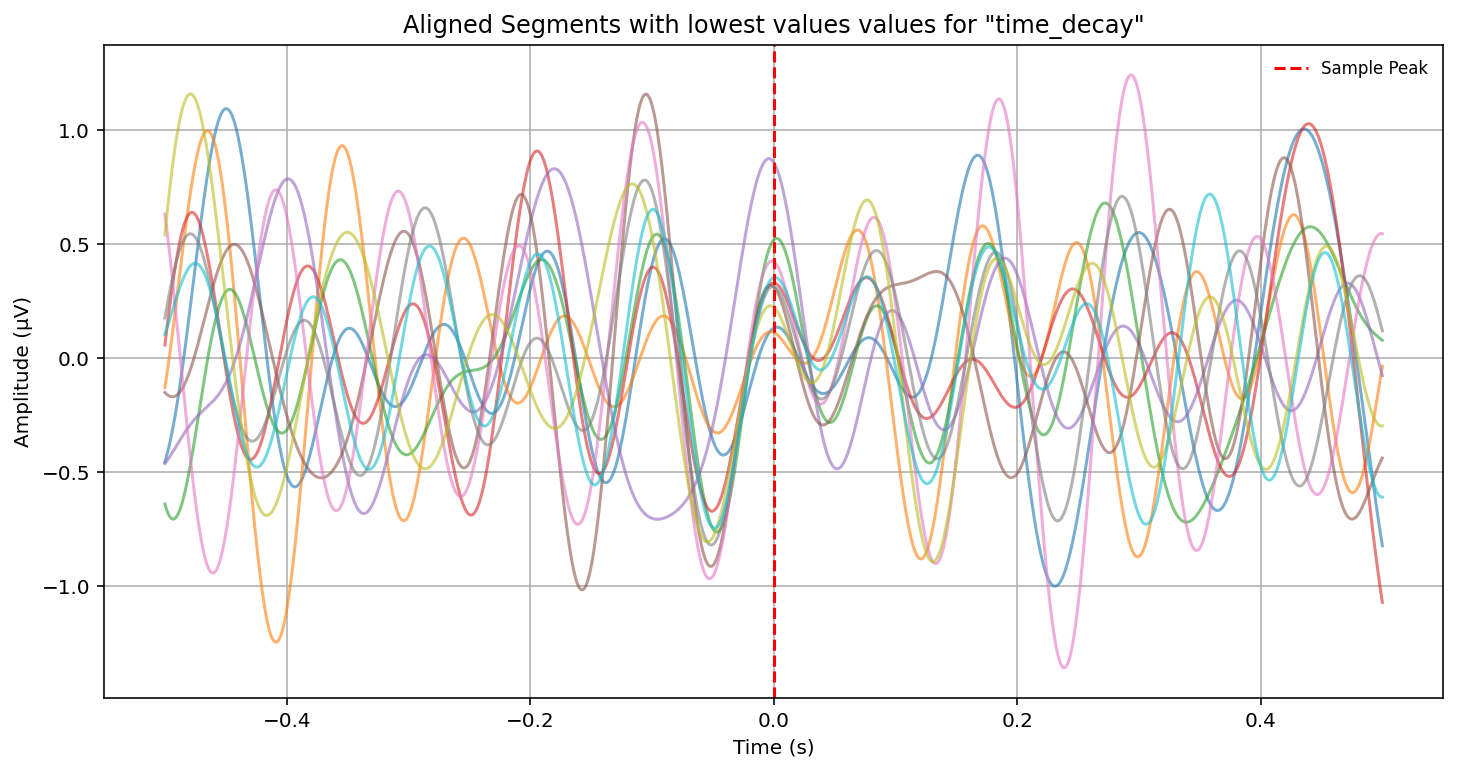

In [153]:
#Plot segments with highest and lowest values for different variables so Monique's team can visualize their meaning 
sampling_rate = 1000  
window_duration = 0.5  
time_vector = np.linspace(-window_duration, window_duration, int(window_duration * 2 * sampling_rate))

plt.figure(figsize=(12, 6))

for i, segment in enumerate(segments_df2['segment']):

        plt.plot(time_vector, segment, alpha=0.6)  

plt.title('Aligned Segments with lowest values values for "time_decay"')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axvline(x=0, color='red', linestyle='--', label='Sample Peak')  
plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
plt.grid(True)
plt.show()

In [ ]:
#plot all cycles on top of another 

plt.figure(figsize=(12, 6))

for i, segment in enumerate(segments_df['segment']):
    if 1000 > i > 990:
        plt.plot(time_vector, segment, alpha=0.6, label=f'Segment {i+1}' if i < 10 else None)  # Limit labels for clarity


plt.title('Aligned Segments')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axvline(x=0, color='red', linestyle='--', label='Sample Peak')  # Mark the reference peak
plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
plt.grid(True)
plt.show()

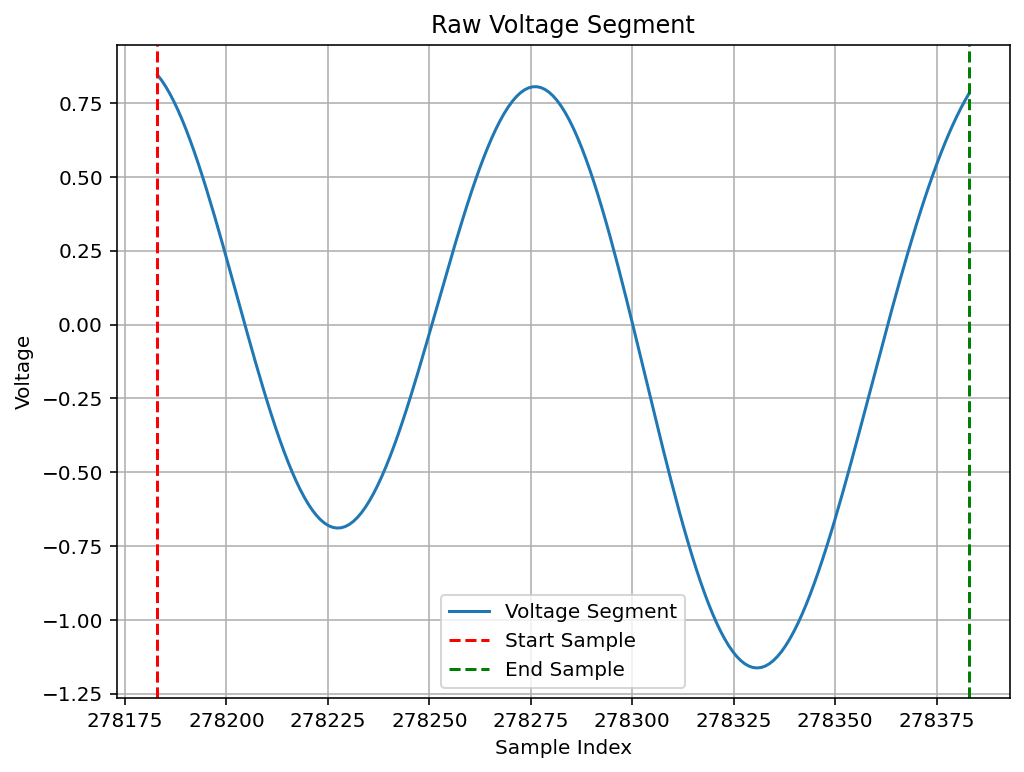

In [43]:
## plot individual cycles 
def plot_raw_segment(voltage_array, start_sample, end_sample):
    """
    Plot a raw segment from the voltage array based on start and end sample indices.

    Parameters:
        voltage_array (np.ndarray): 1D array of voltage values.
        start_sample (int): The start sample index for the segment.
        end_sample (int): The end sample index for the segment.

    Returns:
        None
    """
    segment = preproc_sig2[start_sample:end_sample]
    
    time = np.linspace(start_sample, end_sample, len(segment))
    
    plt.figure(figsize=(8, 6))
    plt.plot(time, segment, label="Voltage Segment")
    plt.axvline(x=start_sample, color='r', linestyle='--', label="Start Sample")
    plt.axvline(x=end_sample, color='g', linestyle='--', label="End Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("Voltage")
    plt.title("Raw Voltage Segment")
    plt.legend()
    plt.grid(True)
    plt.show()

start_sample = 278183 
end_sample = 278383    

plot_raw_segment(preproc_sig2, start_sample=start_sample, end_sample=end_sample)

In [ ]:
## heatmap correlations without excluding within-subject comparisons  

subset_data = df_bycycle_Post_NaN.iloc[:, :17]  #first 17 columns
columns_to_exclude = ['volt_decay', 'volt_rise', 'volt_amp', 'volt_peak', 'volt_trough', 'amp_fraction']  
subset_data = subset_data.drop(columns=columns_to_exclude, errors='ignore') 
correlation_matrix = subset_data.corr()  

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
## HEATMAPS PT2 (excluding within-subject comparisons)
variables_to_include = ['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak']  

post_mouse = df_bycycle_2Post[variables_to_include]
pre_mouse = df_bycycle_2Pre[variables_to_include]

post_mouse.columns = [f"{col}_post_mouse" for col in post_mouse.columns]
pre_mouse.columns = [f"{col}_pre_mouse" for col in pre_mouse.columns]

combined_data = pd.concat([post_mouse, pre_mouse], axis=1)

correlation_matrix = combined_data.corr()

mask = np.zeros_like(correlation_matrix, dtype=bool) 
columns_mouse1 = post_mouse.columns
columns_mouse2 = pre_mouse.columns

# Mask Mouse 1 vs Mouse 1 and Mouse 2 vs Mouse 2 correlations
for col1 in columns_mouse1:
    for col2 in columns_mouse1:
        mask[correlation_matrix.index == col1, correlation_matrix.columns == col2] = True
for col1 in columns_mouse2:
    for col2 in columns_mouse2:
        mask[correlation_matrix.index == col1, correlation_matrix.columns == col2] = True

upper_triangle = np.triu(np.ones_like(correlation_matrix, dtype=bool))
mask |= upper_triangle  

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', cbar=True)
plt.title("Between-Subject Correlations: Mouse 1 vs Mouse 2 (No Redundancy)")
plt.show()

In [112]:
#violin plots of variables of interest pre vs post 

feats_to_plot = {'volt_amp': 'Amplitude (μV)', 
                 'time_ptsym': 'Peak-Trough Asymmetry', 
                 'time_rdsym': 'Rise-Decay Asymmetry'}

def plot_violin_comparison(df1, df2, feats_to_plot):
    fig, axes = plt.subplots(1, len(feats_to_plot), figsize=(15, 5), sharey=True)
    
    for ax, (feat, title) in zip(axes, feats_to_plot.items()):
        data = [df1[feat], df2[feat]]
        ax.violinplot(data, showmeans=True)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Bystander Mouse Post', 'Mouse Post'])
        ax.set_ylabel(title)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

plot_violin_comparison(df_bycycle_ByPost, df_bycycle_Post, feats_to_plot)